# Bayesian Logistic Regression with Feature Engineering for Red Wine Quality Data Set

We perform logistic regression with feature engineering and mean-zero Gaussian prior for the 11-dimensional *red wine quality data set*, as can be retrieved from [Kaggle](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009), normalized so that each feature has sample mean zero and sample variance one. Specifically, we append all two-way interactions between given features to the data. That is, we replace every feature vector $v = (v_1,...v_{d_{\text{raw}}})^T$ in the original data by its augmented version

$$ 
(v_1,...,v_{d_{\text{raw}}}, v_1^2, v_1 v_2, v_2^2, ... , v_{d_{\text{raw}}-1} v_{d_{\text{raw}}}, v_{d_{\text{raw}}}^2, 1 ) \in \mathbb{R}^d ,
$$

so that we end up with $d = 78$.

Denote the augmented data set as $(a^{(i)},b^{(i)})_{i=1,...,n_{\text{data}}} \subset \mathbb{R}^d \times \{-1,1\}$, where $n_{\text{data}} = 1599$.
Our prior is the mean-zero Gaussian $\mathcal{N}_d(0, \sigma^2 I_d)$ with $\sigma^2 = 100$. The likelihood is obtained by the usual logistic regression model. Our target density, the (unnormalized) posterior density, is therefore given by
$$
\varrho(x)
= \mathcal{N}_d(x; 0, \sigma^2 I_d) \prod_{i=1}^{n_{\text{data}}} \frac{1}{1 + \exp(-b^{(i)} \langle a^{(i)}, x \rangle)} , 
\quad x \in \mathbb{R}^d .
$$

**Note:** With the current setting, the experiment requires quite a lot of memory ($> 16$ GB).

In [1]:
from patt_mcmc import patt_ess, patt_gpss
from hit_and_run_uniform_slice_sampling import parallel_hruss
from random_walk_metropolis import parallel_ada_rwm
import mcmc_utils as mcu
import plotting_functions as pfs

In [2]:
import pandas as pd
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import seaborn as sb

In [3]:
path_prefix = "../plots/BLR-FE_wine_quality_"

### Retrieve and Prepare the Data, do Feature Engineering, Construct the Target Density

In [4]:
# load data set from file
data = pd.read_csv("../data/red_wine_quality.csv")
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [5]:
# retrieve features , do feature engineering
raw_feats = data.drop('quality', axis=1)
n_data = raw_feats.shape[0]
d_raw = raw_feats.shape[1]
# normalize features to mean zero and unit variance
medium_feats = ((raw_feats - raw_feats.mean()) / raw_feats.std()).to_numpy()
# do feature engineering (original data, two-way interactions, constant for intercept)
d = d_raw + (d_raw * (d_raw + 1) // 2) + 1
well_done_feats = np.zeros((n_data, d))
well_done_feats[:,:d_raw] = medium_feats
col = d_raw
for i in range(d_raw):
    for j in range(i+1):
        well_done_feats[:,col] = medium_feats[:,i] * medium_feats[:,j]
        col += 1
well_done_feats[:,col] = np.ones(n_data)
# use the resulting features for logistic regression
a = well_done_feats

In [6]:
# assign binary labels ("quality >= 6" -> +1, "quality < 6" -> -1)
labels = data['quality'].to_numpy()
b = np.array(labels >= 6, dtype=int) - np.array(labels < 6, dtype=int)

In [7]:
_, cnts = np.unique(b, return_counts=True)
print("There are {} wine samples of quality < 6 and {} wine samples of quality >= 6.".format(cnts[0],cnts[1]))

There are 744 wine samples of quality < 6 and 855 wine samples of quality >= 6.


In [8]:
# set/retrieve some general parameters
d = a.shape[1]
print("Sample space dimension: d = {}".format(d))
sig_sq = 100 # prior variance

Sample space dimension: d = 78


In [9]:
# construct posterior
def log_density(x):
    return - np.sum(x**2) / (2 * sig_sq) - np.sum(np.log(1 + np.exp(-b * np.inner(a, x))))

### Run the Samplers

In running the samplers, we try to allocate each of them roughly the same computational budget. Regardless of how many iterations a sampler performs and how many parallel chains it uses, we ultimately judge it solely by its performance in the latter half of all of its chains.

Note: If PATT-GPSS is run before HRUSS and AdaRWM, it can break the latter's progress bars, likely due to some sort of incompatibility between tqdm.tqdm and tqdm.notebook.tqdm.

In [10]:
n_chains = 10 # number of parallel chains permitted to each sampler
n_its = int(1e5) # total number of iterations per chain, per sampler (except AdaRWM)
x_0s = rnd.normal(size=(n_chains,d)) # suggested initial states

#### Hit-and-Run Uniform Slice Sampling

In [11]:
w_hruss = 1.0

In [12]:
samples_hruss, tde_hruss = parallel_hruss(log_density, n_chains, n_its, x_0s, w_hruss)

Checking validity of given arguments...
Preparing for parallel sampling...
Starting parallel sampling...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:29<00:00, 1113.66it/s]


Processing returns and terminating...


#### Adaptive Random Walk Metropolis
Note: We grant AdaRWM significantly more iterations than PATT-GPSS and HRUSS because it has a much lower computational cost per iteration by virtue of only using one TDE per iteration.

In [13]:
n_its_rwm = 5 * n_its

In [14]:
samples_rwm, ldv_rwm, means_rwm, cov_rwm = parallel_ada_rwm(log_density, n_chains, n_its_rwm, x_0s)

Checking validity of given arguments...
Preparing for parallel sampling...
Starting parallel sampling...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 500000/500000 [03:26<00:00, 2427.16it/s]


Processing returns and terminating...


In [15]:
tde_rwm = np.ones((n_its_rwm+1,n_chains), dtype=int)

In [16]:
# special exception: to save memory we already summarize and then delete the means of RWM at this point
norms_rwm = mcu.get_radii(means_rwm)
del means_rwm

#### PATT Elliptical Slice Sampling

In [17]:
n_burn_ess = n_its // 10
n_its_ess = n_its - n_burn_ess

In [18]:
ret_dic = patt_ess(
    log_density,
    n_chains,
    n_burn_ess,
    n_its_ess,
    x_0s,
    cen_mode='mean',
    cov_mode='cov',
)

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...


/tmp/ipykernel_60126/3164087956.py:3: RuntimeWarning: overflow encountered in exp
  return - np.sum(x**2) / (2 * sig_sq) - np.sum(np.log(1 + np.exp(-b * np.inner(a, x))))
/tmp/ipykernel_60126/3164087956.py:3: RuntimeWarning: overflow encountered in exp
  return - np.sum(x**2) / (2 * sig_sq) - np.sum(np.log(1 + np.exp(-b * np.inner(a, x))))
/tmp/ipykernel_60126/3164087956.py:3: RuntimeWarning: overflow encountered in exp
  return - np.sum(x**2) / (2 * sig_sq) - np.sum(np.log(1 + np.exp(-b * np.inner(a, x))))
/tmp/ipykernel_60126/3164087956.py:3: RuntimeWarning: overflow encountered in exp
  return - np.sum(x**2) / (2 * sig_sq) - np.sum(np.log(1 + np.exp(-b * np.inner(a, x))))


Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/90001 [00:00<?, ?it/s]

Assembling output...


In [19]:
samples_ess = np.concatenate([ret_dic['burn-in'], ret_dic['samples'][1:]], axis=0)
tde_ess = np.concatenate([ret_dic['tde_cnts_burn'], ret_dic['tde_cnts'][1:]], axis=0)
means_ess = ret_dic['means']
covs_ess = ret_dic['covs']
schedule_ess = ret_dic['schedule']

#### PATT Gibbsian Polar Slice Sampling

In [20]:
n_burn_gpss = n_its // 10
n_its_gpss = n_its - n_burn_gpss
w_burn = 1.0
w_att = np.sqrt(d) / 2

In [21]:
ret_dic = patt_gpss(
    log_density,
    n_chains,
    n_burn_gpss,
    n_its_gpss,
    x_0s,
    cen_mode='mean',
    cov_mode='cov',
    w_burn=w_burn,
    w_att=w_att,
)

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/90001 [00:00<?, ?it/s]

Assembling output...


In [22]:
samples_gpss = np.concatenate([ret_dic['burn-in'], ret_dic['samples'][1:]], axis=0)
tde_gpss = np.concatenate([ret_dic['tde_cnts_burn'], ret_dic['tde_cnts'][1:]], axis=0)
means_gpss = ret_dic['means']
covs_gpss = ret_dic['covs']
schedule_gpss = ret_dic['schedule']

#### Two-Group Generalized Elliptical Slice Sampling

We refrain from running GESS in this experiment because it would want to run $4d = 312$ different chains ($2d$ per group for each of its two groups), requiring so much runtime and memory that it would seriously jeopardize the run-ability of the experiment.

### Analyze Sampling Performance

In [24]:
snames = ["PATT-ESS", "PATT-GPSS", "HRUSS", "AdaRWM"]
full_samples = [samples_ess, samples_gpss, samples_hruss, samples_rwm]
full_tde = [tde_ess, tde_gpss, tde_hruss, tde_rwm]
n_burns = np.array([n_its, n_its, n_its, n_its_rwm], dtype=int) // 2
nsam = len(snames)

In [25]:
burn_samples = [fs[:nb] for fs, nb in zip(full_samples, n_burns)]
samples = [fs[nb:] for fs, nb in zip(full_samples, n_burns)]
burn_tde = [ft[:nb] for ft, nb in zip(full_tde, n_burns)]
tde = [ft[nb:] for ft, nb in zip(full_tde, n_burns)]
full_radii = mcu.get_radii_list(full_samples)
burn_radii = mcu.get_radii_list(burn_samples)
radii = mcu.get_radii_list(samples)
flat_steps = mcu.get_flat_steps_list(samples)
pos_mean_ests = [np.mean(sams, axis=(0,1)) for sams in samples]

In [26]:
# the IAT computation takes a while
mean_burn_tde = mcu.mean_tde_list(burn_tde)
mean_tde = mcu.mean_tde_list(tde)
maxls = [1000, 1000, int(1e4), int(1e4)]
mean_iats = mcu.mean_iat_multi_chain_list(samples, maxls)
msss = mcu.mss_list(samples)
accuracy = lambda coef: np.mean(np.sign(np.inner(a, coef)) == b)
accuracies = [accuracy(pme) for pme in pos_mean_ests]

In [27]:
pd.DataFrame(
    np.array([
        snames,
        np.round(mean_burn_tde, 2),
        np.round(mean_tde, 2),
        np.round(mean_iats, 2),
        np.round(msss, 2),
        np.round(mean_tde * mean_iats, 2), # TDE per effective sample = total TDE / total ES = TDE/it / ES/it = TDE/it / IAT
        np.round(mean_tde / msss, 2), # = TDE/it * (its to move by 1) = TDE to move by 1
        np.round(accuracies, 3),
    ]).T,
    columns = [
        "Sampler",
        "Burn-In TDE/it",
        "TDE/it",
        "mean IAT",
        "MSS",
        "TDE/ES",
        "TDE/MSS",
        "Accuracy",
    ]
)

,Sampler,Burn-In TDE/it,TDE/it,mean IAT,MSS,TDE/ES,TDE/MSS,Accuracy
0,PATT-ESS,5.61,2.52,5.0,1.7,12.61,1.49,0.769
1,PATT-GPSS,9.63,7.36,3.81,1.8,28.01,4.1,0.769
2,HRUSS,6.02,6.05,4481.99,0.05,27133.66,119.42,0.77
3,AdaRWM,1.0,1.0,2677.48,0.03,2677.48,31.46,0.769


### Plotting

In [28]:
n_win = int(1e4)

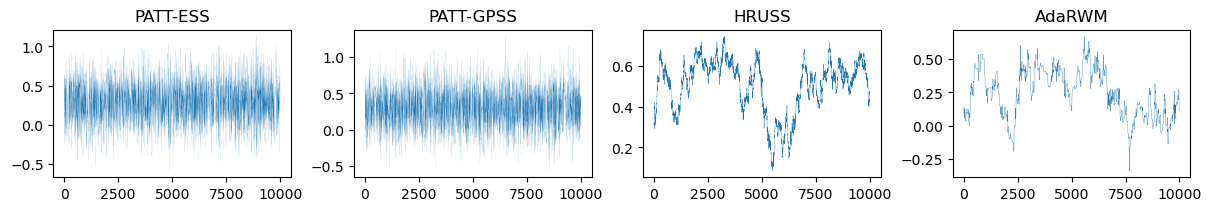

In [29]:
lws = [0.05, 0.05, 0.25, 0.25]
path = path_prefix + "marginal_trace.png"
pfs.trace_plot_row([sams[-n_win:,0,0] for sams in samples], snames, filepath=path, lws=lws)

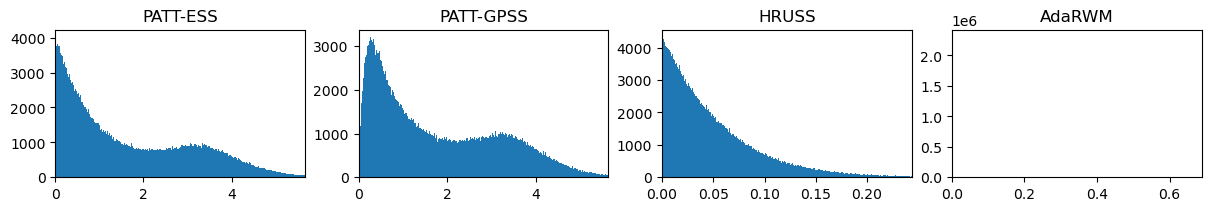

In [30]:
plot_steps = [np.copy(fs) for fs in flat_steps]
plot_steps[2] = plot_steps[2][plot_steps[2] != 0.0]
path = path_prefix + "steps.png"
pfs.plot_step_hist_row(plot_steps, snames, filepath=path)

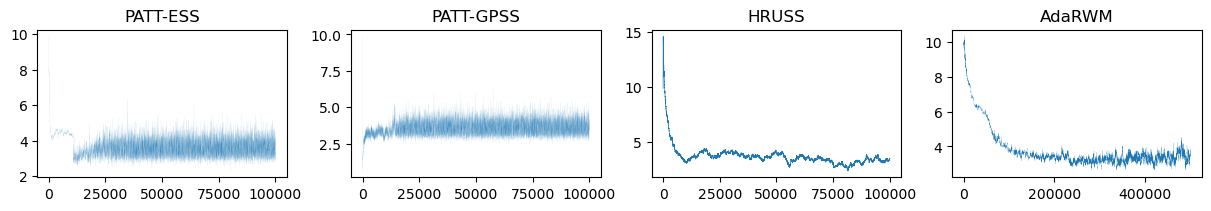

In [31]:
lws = [0.025, 0.025, 0.5, 0.1]
pfs.trace_plot_row([frs[:,0] for frs in full_radii], snames, lws=lws)

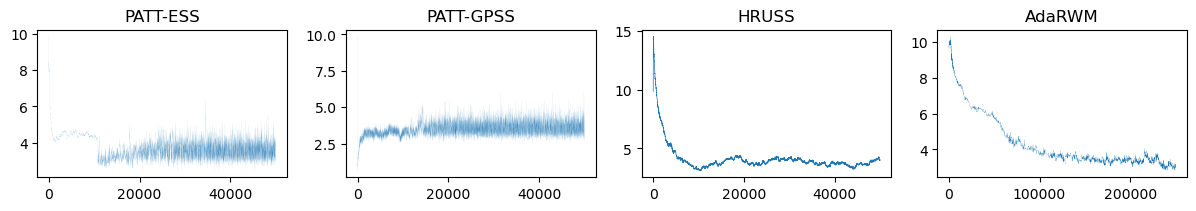

In [32]:
pfs.trace_plot_row([brs[:,0] for brs in burn_radii], snames, lws=lws)

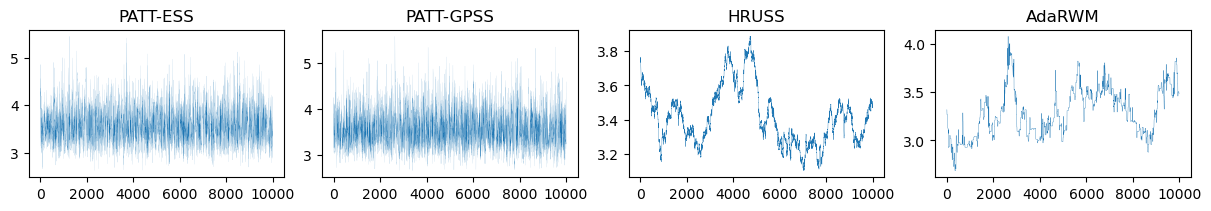

In [33]:
lws = [0.05, 0.05, 0.25, 0.25]
pfs.trace_plot_row([rs[-n_win:,0] for rs in radii], snames, lws=lws)

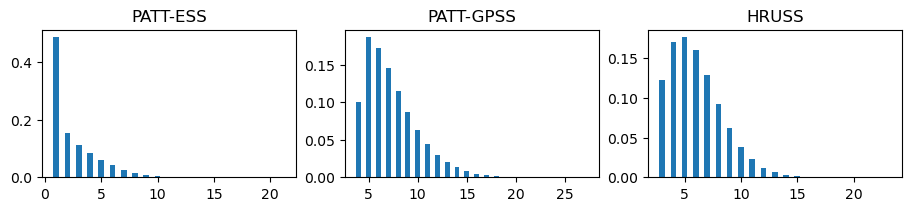

In [34]:
no_rwm = [0,1,2]
pfs.plot_tde_distr_row([tde[i] for i in no_rwm], [snames[i] for i in no_rwm])

In [35]:
acc_rates_rwm = np.mean(ldv_rwm[n_its_rwm//2+1:] != ldv_rwm[n_its_rwm//2:-1], axis=0)
print("Average AdaRWM acceptance rate: {:.3f}".format(np.mean(acc_rates_rwm)))
print("Minimal AdaRWM acceptance rate: {:.3f}".format(np.min(acc_rates_rwm)))
print("Maximal AdaRWM acceptance rate: {:.3f}".format(np.max(acc_rates_rwm)))

Average AdaRWM acceptance rate: 0.077
Minimal AdaRWM acceptance rate: 0.057
Maximal AdaRWM acceptance rate: 0.093


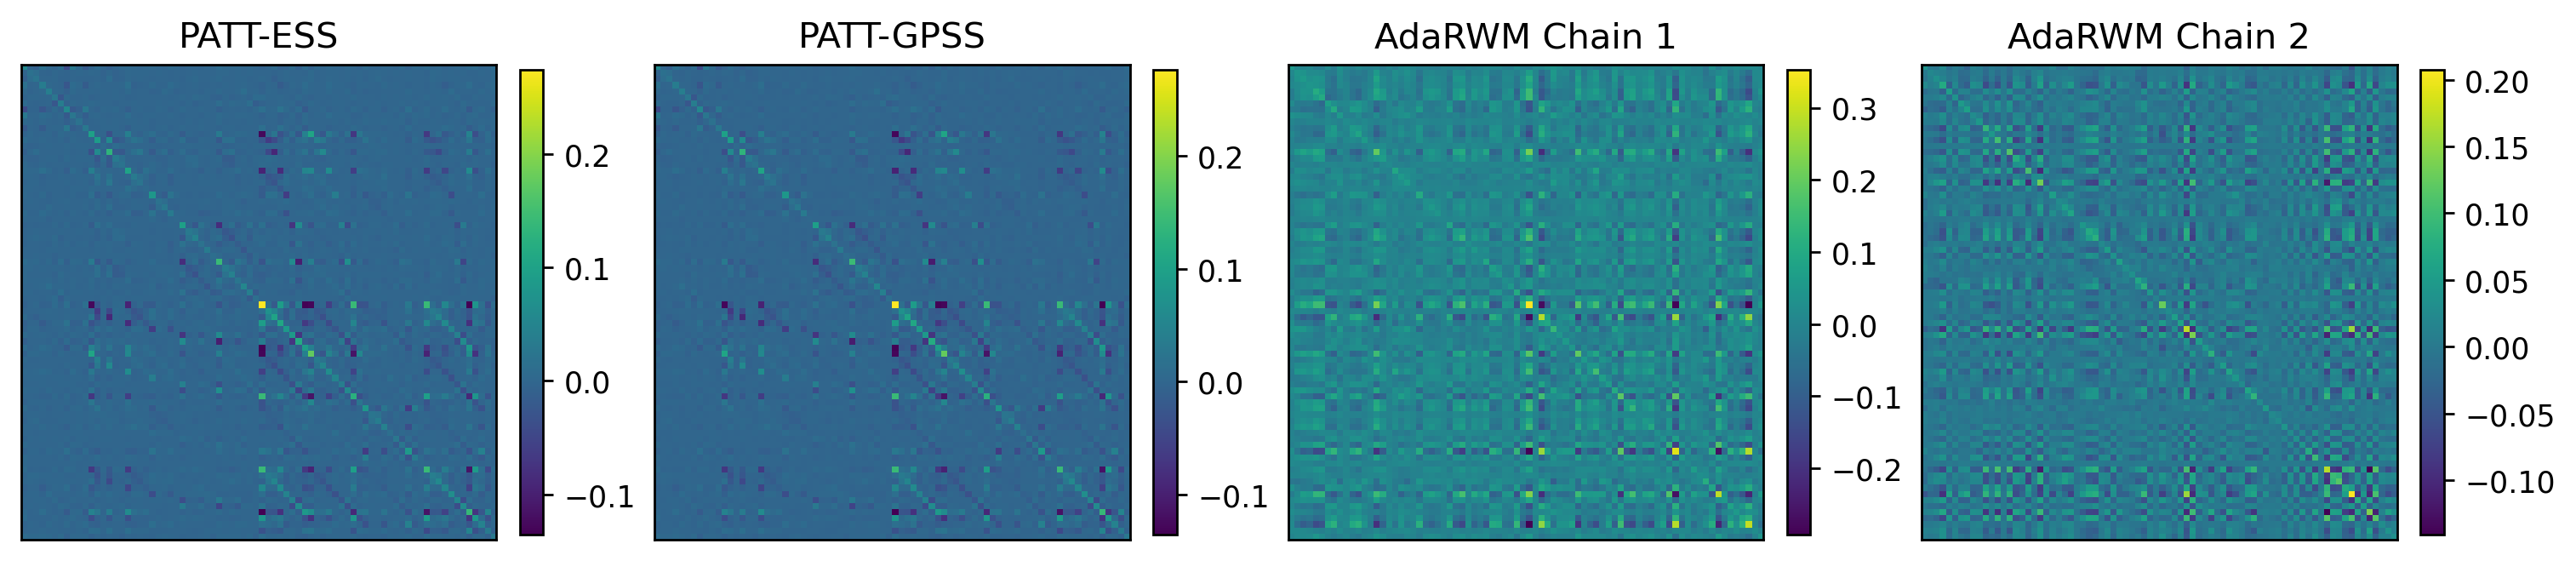

In [36]:
titles = ["PATT-ESS", "PATT-GPSS", "AdaRWM Chain 1", "AdaRWM Chain 2"]
covs = [covs_ess[-1], covs_gpss[-1], cov_rwm[0], cov_rwm[1]]
path = path_prefix + "covs.png"
pfs.plot_covs_row(covs, titles, filepath=path)

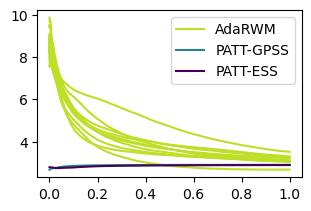

In [38]:
# plot progressions of the norm of each sampler's posterior mean approximation
norms_ess = mcu.get_radii(means_ess)
norms_gpss = mcu.get_radii(means_gpss)
colors = plt.cm.viridis(np.linspace(0, 0.9, 3))
pfs.initiate((3,2),100)
plt.plot(np.linspace(0,1,n_its_rwm+1), norms_rwm[:,0], color=colors[2], label=snames[3])
for i in range(1,n_chains):
    plt.plot(np.linspace(0,1,n_its_rwm+1), norms_rwm[:,i], color=colors[2])
plt.plot(schedule_gpss / schedule_gpss[-1], norms_gpss, color=colors[1], label=snames[1])
plt.plot(schedule_ess / schedule_ess[-1], norms_ess, color=colors[0], label=snames[0])
plt.legend(loc='upper right')
pfs.wrapup()

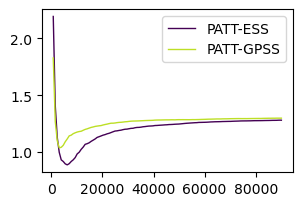

In [39]:
# plot progressions of the norm of the PATT samplers' posterior covariance approximations
cov_norms_ess = mcu.get_radii(covs_ess.reshape(schedule_ess.shape[0],-1))
cov_norms_gpss = mcu.get_radii(covs_gpss.reshape(schedule_gpss.shape[0],-1))
colors = plt.cm.viridis(np.linspace(0, 0.9, 2))
pfs.initiate((3,2),100)
plt.plot(schedule_ess[1:], cov_norms_ess[1:], color=colors[0], linewidth=1)
plt.plot(schedule_gpss[1:], cov_norms_gpss[1:], color=colors[1], linewidth=1)
plt.legend(snames[:2])
pfs.wrapup()

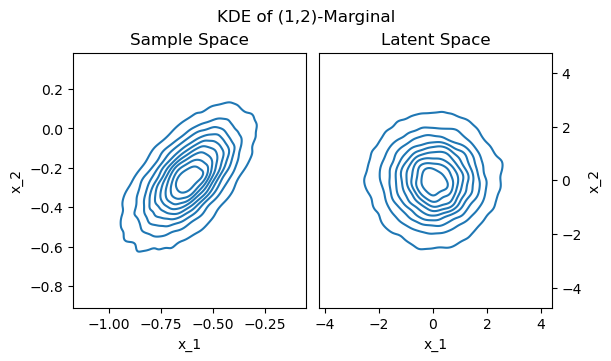

In [40]:
# plot a bivariate marginal KDE in sample space and (PATT-ESS's final) latent space
inds = [1,2]
ax_labels = ["x_{}".format(inds[0]), "x_{}".format(inds[1])]
fig, axes = plt.subplots(1,2, figsize=(6,3.5), dpi=100, constrained_layout=True)
fig.suptitle("KDE of ({},{})-Marginal".format(inds[0], inds[1]))
# left column: bivariate marginal in sample space
axes[0].set_title("Sample Space")
biv_sample_sp = np.concatenate([samples[0][:,0,inds[0]].reshape(-1,1),
                                samples[0][:,0,inds[1]].reshape(-1,1)], axis=1)
biv_sample_sp_frame = pd.DataFrame(biv_sample_sp, columns=ax_labels)
sb.kdeplot(biv_sample_sp_frame, x=ax_labels[0], y=ax_labels[1], ax = axes[0])
# right column: bivariate marginal in latent space
axes[1].set_title("Latent Space")
L = np.linalg.cholesky(covs_gpss[-1])
L_inv = np.linalg.inv(L)
alpha_inv = lambda y: L_inv @ (y - means_gpss[-1])
plot_latent_samples = np.apply_along_axis(alpha_inv, -1, samples[0][:,0])
biv_latent_sp = np.concatenate([plot_latent_samples[:,inds[0]].reshape(-1,1),
                                plot_latent_samples[:,inds[1]].reshape(-1,1)], axis=1)
biv_latent_sp_frame = pd.DataFrame(biv_latent_sp, columns=ax_labels)
sb.kdeplot(biv_latent_sp_frame, x=ax_labels[0], y=ax_labels[1], ax = axes[1])
axes[1].yaxis.tick_right()
axes[1].yaxis.set_label_position("right")
pfs.wrapup()

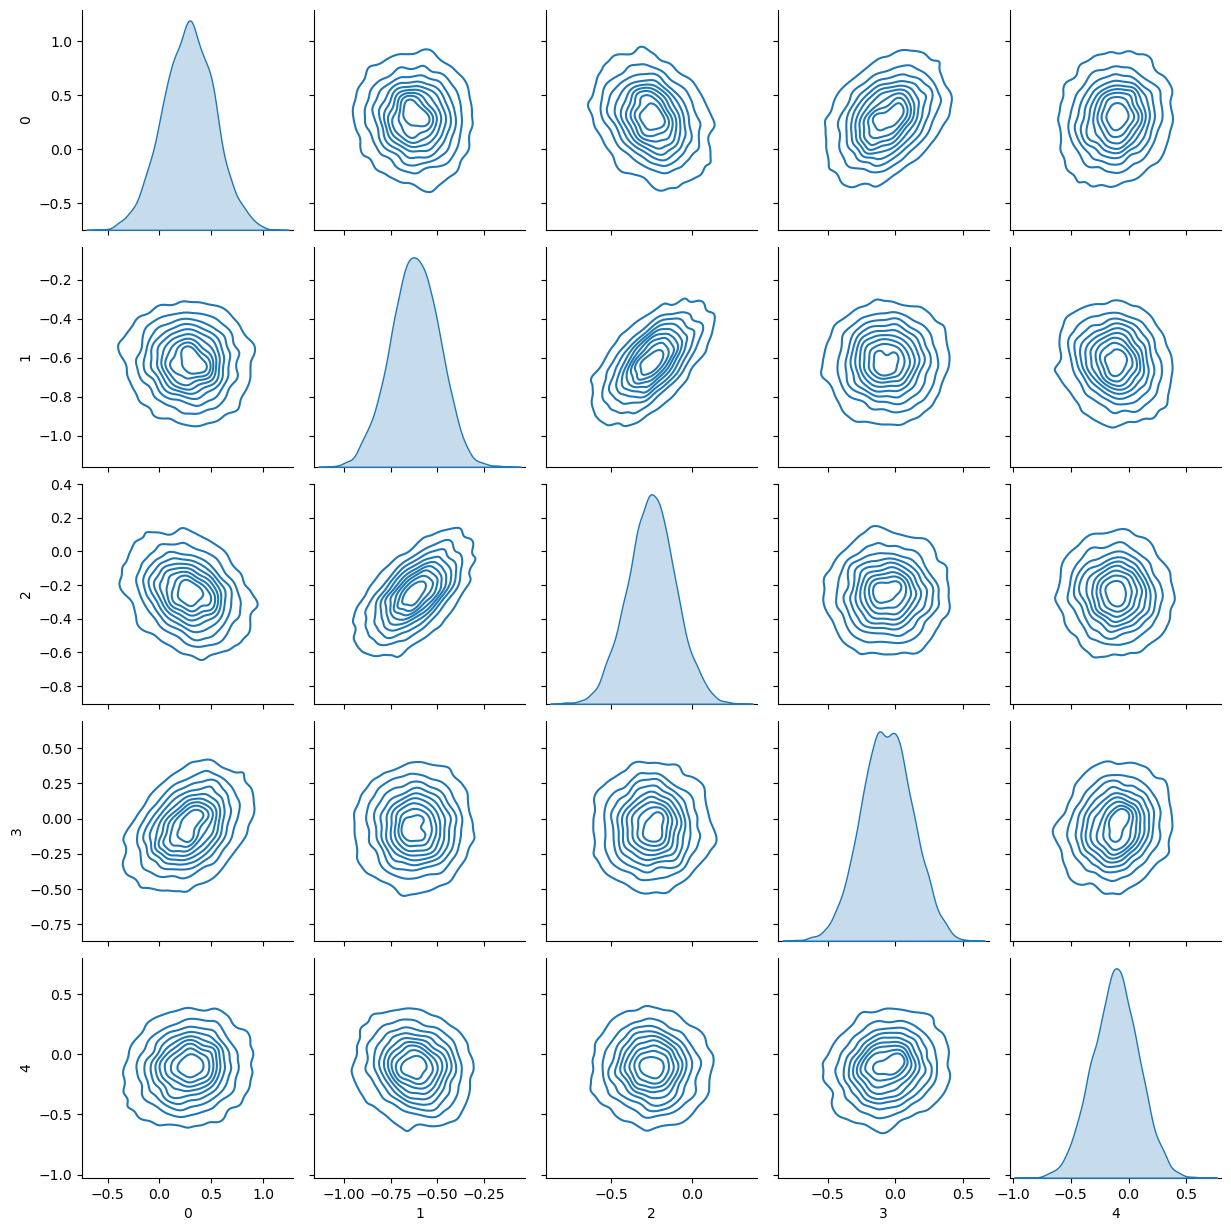

In [41]:
# this cell may take 1-2 min to run
sb.pairplot(pd.DataFrame(samples[0][-n_win:,0,:5]), kind='kde')
plt.show()

In [42]:
pos_mean_ests[0]

array([ 2.88173297e-01, -6.21291047e-01, -2.53425661e-01, -6.26026337e-02,
       -1.10905450e-01,  5.48267018e-01, -7.54772476e-01, -2.04824458e-01,
       -1.91614531e-01,  9.48721805e-01,  1.16742281e+00, -4.92104189e-01,
       -4.37659255e-01,  1.02321472e-01, -3.17295657e-01,  4.28884134e-01,
        1.92154047e-01, -3.52038747e-01, -1.61948494e-01, -1.03263633e-01,
       -2.39352045e-02, -6.63681589e-01,  1.55408263e-02,  5.86759661e-02,
        1.65766337e-01, -4.03714285e-02, -1.22105082e-01, -1.26385881e-01,
        1.25972099e-01,  2.05678937e-01, -9.58604980e-02, -1.80525254e-01,
        4.70148241e-02,  2.26253403e-01, -2.98735622e-02,  9.32887839e-02,
       -4.04636516e-01, -2.10127082e-01, -5.75758959e-02,  6.19793852e-01,
        1.58132486e-01, -7.23759850e-02,  1.57788068e-01,  7.19994209e-02,
        5.75185149e-03, -3.69652634e-01,  1.99364805e-02,  3.95371189e-03,
       -2.21211252e-01, -4.88242890e-01, -1.26489826e-01, -3.10503683e-01,
        1.08040151e-01, -